In [253]:
import re
import random
import pandas as pd
import hashlib

In [254]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.5) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [255]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
DAX,29.841161,3.315685,5.196999,9
Email Auth and Security,204.019855,51.004964,75.953452,4
Azure VM + Developer,316.614178,9.312182,17.601016,34
"Jane Eyre, Bronte",339.310428,42.413803,63.297429,8
TSQL,633.000811,26.375034,33.126537,24
Azure AD Authentication,799.633203,66.636100,142.160495,12
RAG Project,835.375788,92.819532,242.294567,9
Logging in Python,929.942541,66.424467,110.712028,14
Azure Private DNS,1485.921649,78.206403,154.489443,19
C# Basics,1959.309897,63.203545,114.084410,31


# Histogram

sum of ages: ~47956.16


<Axes: >

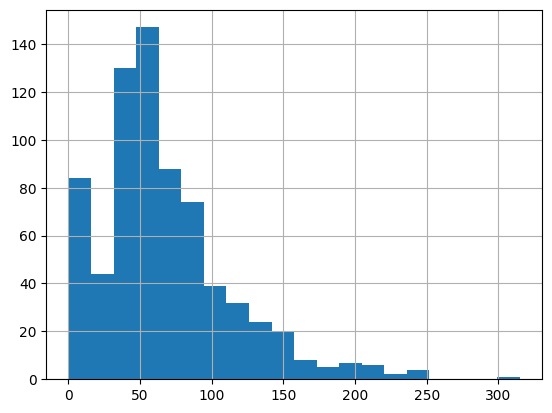

In [256]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~47956.16


<Axes: >

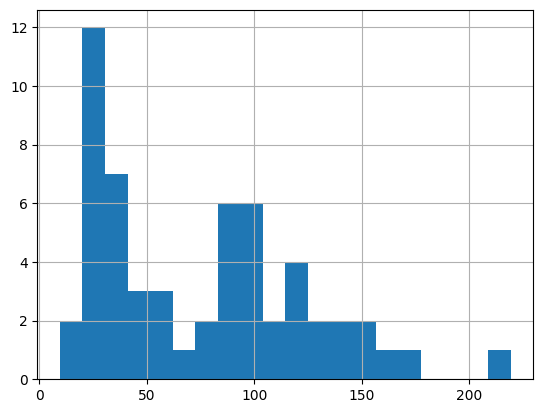

In [257]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [258]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [259]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [260]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [261]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [262]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [263]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [264]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [265]:
n=3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 715
Total card age: 47956.16


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
92,Azure Developer Associate,The code segment acr repository delete --name ...,3e0c920bbcca10037612214b9300db45,-219.380984,76.373937,219.380984,-4353.314414,0.212141,0,0
93,Azure Developer Associate,Application Insights allows you to create web ...,5719d76aaedb7a5f393c0ec7e8e60f91,-152.178750,76.373937,219.380984,-4353.314414,0.212141,3,0
94,Azure Developer Associate,How do you set a container group to restart on...,19ef645a0da6a271fc6613c236edeac5,-138.966508,76.373937,219.380984,-4353.314414,0.212141,6,0
338,Azure Developer Associate,You manage a multi-instance deployment of an A...,1f2dc810672133b69da3f94267e157ff,-120.951534,76.373937,219.380984,-4353.314414,0.212141,9,0
96,Azure Developer Associate,This item tests the candidate’s knowledge of s...,ae1a383233458dcfa12882c4522e2a53,-115.403322,76.373937,219.380984,-4353.314414,0.212141,12,0
97,Azure Developer Associate,A company plans to create an Azure Functions a...,ee25e9d85202d283c9e9b8d843c1414e,-102.575215,76.373937,219.380984,-4353.314414,0.212141,15,0
578,Azure Developer Associate,You manage an Azure event hub.\nYou need to en...,838e25a55fa8576e625cbde1871dbfd0,-97.647564,76.373937,219.380984,-4353.314414,0.212141,18,0
342,Azure Developer Associate,What's the recommended authentication method f...,92c7baf1544a3d6d4ced3a3057810fec,-91.463716,76.373937,219.380984,-4353.314414,0.212141,21,0
100,Azure Developer Associate,Azure Monitor Resource Health alerts are used ...,059f4beba5b43f0dfaf51e36df00e01b,-85.645228,76.373937,219.380984,-4353.314414,0.212141,24,0
101,Azure Developer Associate,"In Azure Application Insights, Preaggregated s...",057ceeb01268094ef085807f1b4e48eb,-79.528480,76.373937,219.380984,-4353.314414,0.212141,27,0


## Age Mean

In [266]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [267]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [268]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [269]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [270]:
existing_cards.sort_values('age', ascending=False).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
128,C# Basics,.NET uses a garbage collector that automatical...,43bedaac447bb0b9a8a6f14b650981e4,-0.250293,63.203545,114.084410,-1959.309897,0.672427,30,0
454,JavaScript Concepts,JavaScript's array destructuring syntax is a c...,d1873d9f239196132e5ff5341adb3922,-0.905176,47.575633,240.816448,-3853.626277,0.510691,80,2
241,DAX,KEEPFILTERS vs. ALL/REMOVEFILTERS (and other m...,5d7a1a933dccd50da553422291e161c0,-1.068543,3.315685,5.196999,-29.841161,0.087534,8,2
688,JavaScript Concepts,Front: How do you create multiline strings usi...,0576807b2b6955c94c9c49ed2cf9a6b8,-1.114094,47.575633,240.816448,-3853.626277,0.510691,79,1
213,JavaScript Concepts,Many operators coerce the operands into number...,c7910dc971abc5da390f0193c2ffbdc8,-1.413356,47.575633,240.816448,-3853.626277,0.510691,78,0
690,JavaScript Concepts,Callback\nA function passed as an argument to ...,9b3cd917f72d441abfeee7a79c32a076,-1.453734,47.575633,240.816448,-3853.626277,0.510691,77,2
687,JavaScript Concepts,Front: What are tagged templates and how do yo...,c01058319c7e76b3d1c1a0e23a0ab7af,-1.635986,47.575633,240.816448,-3853.626277,0.510691,76,1
686,JavaScript Concepts,Bracket Notation: You can also use bracket not...,961a8466fc666d52f999cd6c5124cbb9,-1.723310,47.575633,240.816448,-3853.626277,0.510691,75,0
455,JavaScript Concepts,If the addition operator + is used for primiti...,9cb500afa3eac8e680fbc3cd173ada6b,-1.745925,47.575633,240.816448,-3853.626277,0.510691,74,2
215,JavaScript Concepts,"In JavaScript, you can only return exactly one...",ff371a8725914a03ceed40564889f505,-1.760464,47.575633,240.816448,-3853.626277,0.510691,73,1


In [271]:
existing_cards.head(10).sum()

head                   Azure Developer AssociateAzure Developer Assoc...
body                   The code segment acr repository delete --name ...
hash                   3e0c920bbcca10037612214b9300db455719d76aaedb7a...
age                                                         -1203.741301
subject_mean_age                                              763.739371
subject_highest_age                                          2193.809843
subject_age_sum                                             -43533.14414
head_random_roll                                                2.121411
count                                                                135
n_fold                                                                 0
dtype: object

In [272]:
existing_cards['age'].mean()

-67.07155661873128